<a href="https://colab.research.google.com/github/gelgel5633/self-study/blob/main/%ED%95%84%EC%82%AC/Mercari_Price_Suggestion_Challenge_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 출처
- 노트북 제목 : A simple nn solution with Keras (~0.48611 PL)
- competition명 : Mercari Price Suggestion Challenge
- 노트북 링크 : https://www.kaggle.com/code/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl/notebook

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
# 기존 from sklearn.cross_validation import train_test_split에서 변경됨
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import math

from subprocess import check_output

In [2]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5
    # 참고링크는 이곳에 : https://www.kaggle.com/marknagelberg/rmsle-function

In [3]:
# 데이터 불러오기
train = pd.read_table("/content/drive/MyDrive/transcription_data/Mercari Price Suggestion Challenge/train.tsv")
test = pd.read_table("/content/drive/MyDrive/transcription_data/Mercari Price Suggestion Challenge/test.tsv")
train.shape, test.shape

((1482535, 8), (693359, 7))

In [4]:
# 결측치 다루기
def handle_missing(dataset):
    dataset.category_name.fillna(value = "missing", inplace = True)
    dataset.brand_name.fillna(value = "missing", inplace = True)
    dataset.item_description.fillna(value = "missing", inplace = True)
    return (dataset)

train = handle_missing(train)
test = handle_missing(test)
train.shape, test.shape

((1482535, 8), (693359, 7))

In [5]:
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [6]:
# 범주형 데이터 처리
le = LabelEncoder()

# train과 test를 가로로 쌓아서 라벨인코더 사용
# data leakage 문제가 발생할 여지가 있음
le.fit(np.hstack([train.category_name, test.category_name]))
train.category_name = le.transform(train.category_name)
test.category_name = le.transform(test.category_name)

le.fit(np.hstack([train.brand_name, test.brand_name]))
train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)
del le

train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...


In [7]:
# raw 텍스트 처리
from keras.preprocessing.text import Tokenizer

# 문자열을 사용하는 모든 데이터를 병합
raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])

# tokenizer 학습중
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)

train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.str.lower())
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.str.lower())
train["seq_name"] = tok_raw.texts_to_sequences(train.name.str.lower())
test["seq_name"] = tok_raw.texts_to_sequences(test.name.str.lower())
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"


In [8]:
# 순차 변수 분석
max_name_seq = np.max([np.max(train.seq_name.apply(lambda x: len(x))), np.max(test.seq_name.apply(lambda x: len(x)))])
max_seq_item_description = np.max([np.max(train.seq_item_description.apply(lambda x: len(x))), np.max(test.seq_item_description.apply(lambda x: len(x)))])
print("가장 긴 name 시퀀스는 :"+str(max_name_seq))
print("가장 긴 아이템 설명 시퀀스는 :"+str(max_seq_item_description))

가장 긴 name 시퀀스는 :17
가장 긴 아이템 설명 시퀀스는 :269


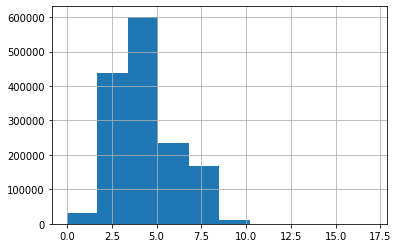

In [9]:
train.seq_name.apply(lambda x: len(x)).hist()

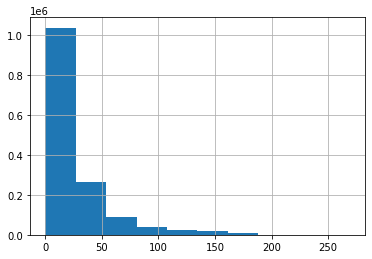

In [10]:
train.seq_item_description.apply(lambda x: len(x)).hist()

In [11]:
# 최대값 임베딩
# 히스토그램에 근거해서 우리는 다음 길이를 선택합니다.
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train.seq_name.max()), np.max(test.seq_name.max()), 
                   np.max(train.seq_item_description.max()), np.max(test.seq_item_description.max())]) + 2
MAX_CATEGORY = np.max([train.category_name.max(), test.category_name.max()]) + 1
MAX_BRAND = np.max([train.brand_name.max(), test.brand_name.max()]) + 1
MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()]) + 1                  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feb9fab2690>]],
      dtype=object)

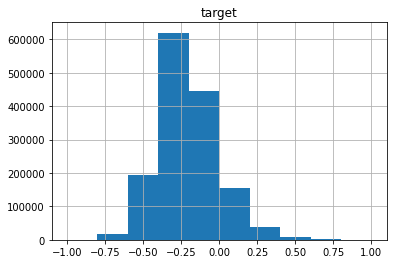

In [12]:
# target변수 스케일링
train["target"] = np.log(train.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))

# pandas series.reshape는 삭제됨
# 따라서 numpy로 바꿔준 이후 사용해야함
# 참고링크 : https://splunktool.com/how-to-fix-attributeerror-series-object-has-no-attribute-tonumpy
train["target"] = target_scaler.fit_transform(np.array(train["target"]).reshape(-1,1))
pd.DataFrame(train.target).hist()

In [13]:
# 개발테스트용 추출, 원문은 EXTRACT DEVELOPMENT TEST
dtrain, dvalid = train_test_split(train, random_state = 123, train_size = 0.99)
dtrain.shape, dvalid.shape

((1467709, 11), (14826, 11))

In [14]:
# 케라스 데이터 정의
# from keras.preprocessing.sequence import pad_sequences에서 변경됨
from keras.utils import pad_sequences

def get_keras_data(dataset):
    x = {
        "name" : pad_sequences(dataset.seq_name, maxlen = MAX_NAME_SEQ),
         "item_desc" : pad_sequences(dataset.seq_item_description, maxlen = MAX_ITEM_DESC_SEQ),
         "brand_name":np.array(dataset.brand_name),
         "category_name" : np.array(dataset.category_name),
         "item_condition" : np.array(dataset.item_condition_id),
         "num_vars" : np.array(dataset[["shipping"]])
    }
    return x

x_train = get_keras_data(dtrain)
x_valid = get_keras_data(dvalid)
x_test = get_keras_data(test)

In [15]:
# 케라스 모델 정의
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

# 케라스 backend로 고수준의 api를 사용할 수 있습니다.

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

# keras.backend.clip(x, min_value, max_value) 로 사용합니다
# min_value이하, max_value 이상인 값을 최솟값, 최댓값으로 변경합니다

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model():
    #params
    dr_r = 0.1
    
    #Inputs
    name = Input(shape=[x_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[x_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    category_name = Input(shape=[1], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[x_train["num_vars"].shape[1]], name="num_vars")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    #rnn layer
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)
    
    #main layer
    main_l = concatenate([
        Flatten() (emb_brand_name), Flatten() (emb_category_name), Flatten() (emb_item_condition),
        rnn_layer1, rnn_layer2, num_vars
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name
                   , category_name, item_condition, num_vars], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 category_name (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 item_condition (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                              

In [16]:
# 모델 훈련
BATCH_SIZE = 20000
epochs = 5

model = get_model()
model.fit(x_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE, 
          validation_data=(x_valid, dvalid.target), verbose=1)

Epoch 1/5
74/74 [==============================] - 17s 112ms/step - loss: 0.0333 - mae: 0.1378 - rmsle_cust: 0.0167 - val_loss: 0.0189 - val_mae: 0.1045 - val_rmsle_cust: 0.0137
Epoch 2/5
74/74 [==============================] - 7s 101ms/step - loss: 0.0192 - mae: 0.1053 - rmsle_cust: 0.0135 - val_loss: 0.0165 - val_mae: 0.0973 - val_rmsle_cust: 0.0129
Epoch 3/5
74/74 [==============================] - 8s 103ms/step - loss: 0.0168 - mae: 0.0983 - rmsle_cust: 0.0128 - val_loss: 0.0158 - val_mae: 0.0958 - val_rmsle_cust: 0.0125
Epoch 4/5
74/74 [==============================] - 7s 101ms/step - loss: 0.0154 - mae: 0.0941 - rmsle_cust: 0.0123 - val_loss: 0.0155 - val_mae: 0.0944 - val_rmsle_cust: 0.0124
Epoch 5/5
74/74 [==============================] - 8s 102ms/step - loss: 0.0146 - mae: 0.0915 - rmsle_cust: 0.0120 - val_loss: 0.0154 - val_mae: 0.0937 - val_rmsle_cust: 0.0123


In [17]:
# 테스트에서 모델 평가
val_preds = model.predict(x_valid)
val_preds = target_scaler.inverse.transform(val_preds)
val_preds = np.exp(val_preds) + 1

# MAE, MSLE
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_ture, y_pred)
print("RMSLE 에러는 :" +str(v_rmsle))

In [18]:
# 예측 생성
preds = model.predict(x_test, batch_size = BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds) - 1

submission = test[["test_id"]]
submission["price"] = preds

35/35 [==============================] - 1s 24ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


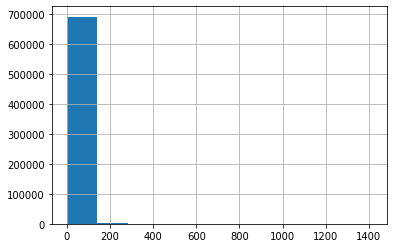

In [19]:
submission.to_csv("./mysubmission.csv", index = False)
submission.price.hist()

이 노트북은 nn으로 문제를 해결할 수 있는 예시입니다. 개선사항은 다음과 같습니다
- 임베딩 요소 증가
- 배치 정규화 추가
- LSTM, Bidirectional RNN, stack RNN
- 밀집층을 사용하거나 더 많은 rnn 출력으로 시도해보세요
- 기타 : 아니면 새로운 시도를 해보세요